In [47]:
import cv2
import matplotlib as plt

from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import rawpy

### Open images

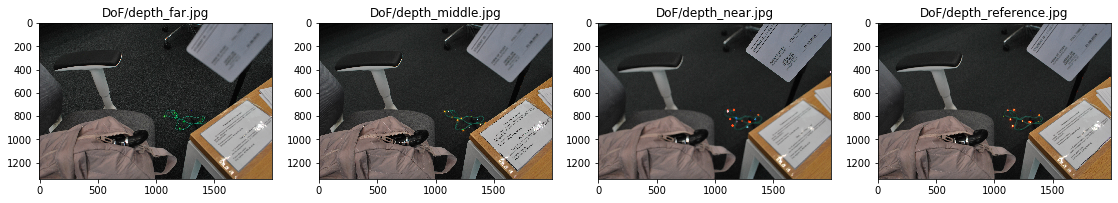

In [48]:
images_pathes = [r"DoF/depth_far.jpg",
                r"DoF/depth_middle.jpg",
                r"DoF/depth_near.jpg",
                r"DoF/depth_reference.jpg"]

def read_images(images_paths, width_img=None):
    images_array = []
    for i in images_paths:
        if i[-3:] == "NEF":
            with rawpy.imread(i) as raw:
                img = raw.postprocess()
        else:
            img = imread(i)
        #resize picture
        if width_img is not None:
            height, width, depth = img.shape
            imgScale = width_img/width
            newX,newY = img.shape[1]*imgScale, img.shape[0]*imgScale
            img = cv2.resize(img,(int(newX),int(newY)))
        
        images_array.append(img)
        
    return np.asarray(images_array)

def print_images(images, rows, cols, titles=None, scale=1):

    fig, ax = plt.subplots(nrows=rows, ncols=cols)
    fig.set_figheight(int(rows * 4 * scale))
    fig.set_figwidth((cols * 4 * scale))
    
    for img, axes, title in zip(images, np.ravel(ax), titles):
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) if len(img.shape) == 4 else img
        axes.imshow(img, cmap="gray")
        if title is not None:
            axes.set_title(title)
    plt.show()
    
images = read_images(images_pathes, width_img=2000)
print_images(images, 1, 4, images_pathes, scale=1.2)

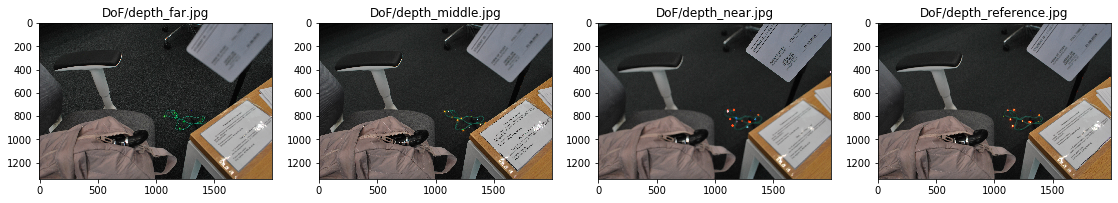

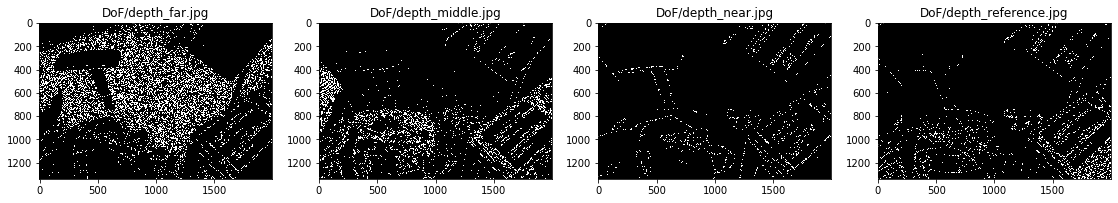

In [12]:


print_images(images, 1, 4, images_pathes, scale=1.2)
edges_images = []
tresholds = []
for image in images:
    sigma=0.33
    v = np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges_images.append(cv2.Canny(image, lower, upper))

print_images(edges_images, 1, 4, titles=images_pathes, scale=1.2)

My dataset is noisy. I will work with dataet from canvas made by instructors

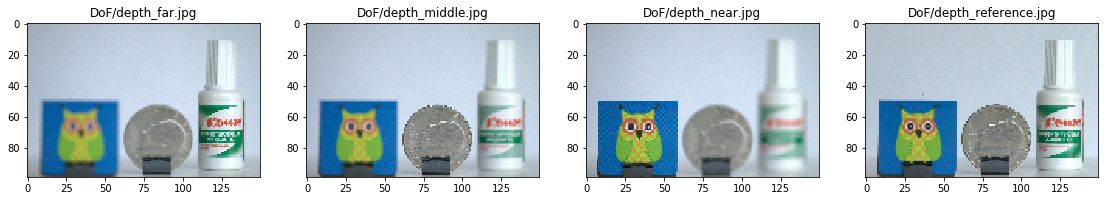

In [49]:
images_pathes_other = [r"img/far.NEF",
                r"img/middle.NEF",
                r"img/near.NEF",
                r"img/reference.NEF"]

images = read_images(images_pathes_other, width_img=150)
print_images(images, 1, 4, images_pathes, scale=1.2)

In [15]:
upCcode('a')

NameError: name 'upCcode' is not defined

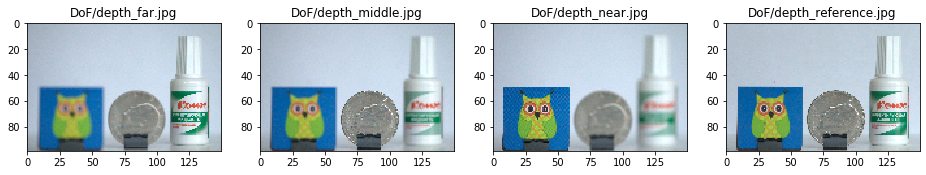

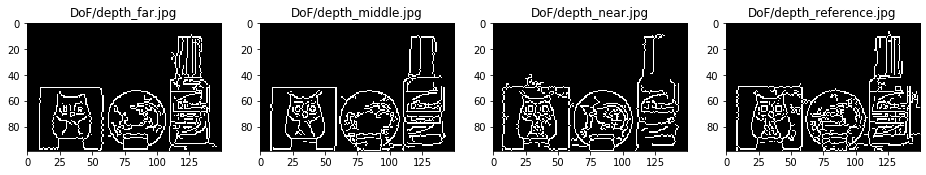

In [30]:
images = read_images(images_pathes_other, width_img=150)
print_images(images, 1, 4, images_pathes, scale=1)
edges_images = []
tresholds = [[20, 100],[50,150],[60,200],[40,200]]
for image in images:
    edges_images.append(cv2.Canny(image, 20, 200))

print_images(edges_images, 1, 4, titles=images_pathes, scale=1)

Images are noisy. Edges detected in not proper way. I will resize images down to 200 pixels in width and make comparison with reference image


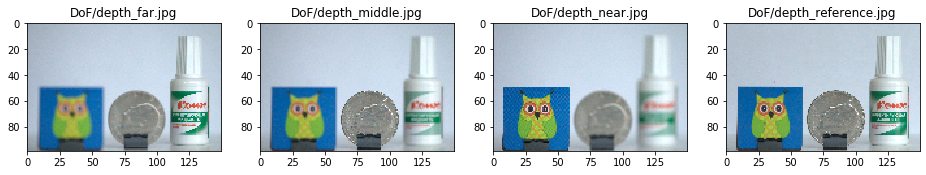

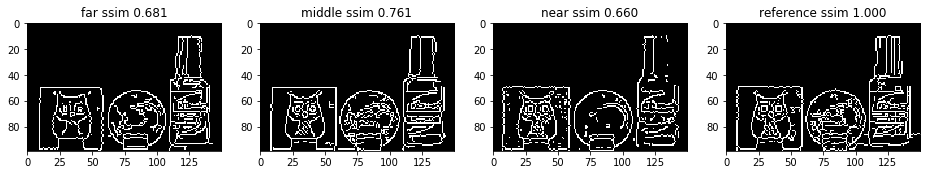

In [31]:
from skimage import measure
#images = read_images(images_pathes_other, width_img=200)
print_images(images, 1, 4, images_pathes, scale=1)
edges_images = []
tresholds = [[50,150],[50,150],[100,110],[50,200]]
ssims = []
for image, thres in zip(images, tresholds):
    edges_images.append(cv2.Canny(image, thres[0], thres[1]))
    
for edge_img in edges_images:
    ssim = measure.compare_ssim(edges_images[-1], edge_img, multichannel=True)
    ssims.append(ssim)
titles = []
for path, ssim in zip(images_pathes_other, ssims):
    path = path.split("/")[-1].split(".")[0]
    ssim = "{:.3f}".format(ssim)
    titles.append(path + " ssim " + ssim)
print_images(edges_images, 1, 4, titles=titles, scale=1)

Resize shows better result for edge detection purpose. However it is not correct, i should implement some filter before Canny filter, for example gaussian. Structural similarity (SSIM) was chosen to measure similarity quantitatively. Oject which are in focus of camera has better continious edges in compare with objects which aren't focused.

### 1.2 Canny filter by yourself

gaussian

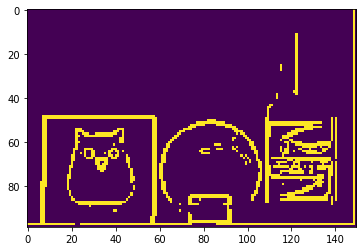

In [12]:
# https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
from scipy import ndimage
from scipy.ndimage.filters import convolve

def Hysteresis(raw_gradients, direction_map, global_thresholds = (20,150)):
    raw_gradients, direction_map = raw_gradients.copy(), direction_map.copy()
    right_value, left_value = -1, -1
    gradiens_padded = np.pad(raw_gradients, pad_width=1, mode='constant', constant_values=0)
    gradients_copy = np.copy(raw_gradients)
    
    # Connectivity of edges. 
    # If from left or right along the direction map the value is big
    allowed_diff = 10
    for i in range(0,raw_gradients.shape[0]):
        for j in range(0, raw_gradients.shape[1]):
            if direction_map[i, j] == 0:
                right_value = gradiens_padded[i + 1, j]
                left_value = gradiens_padded[i - 1, j]
            elif direction_map[i, j] == 45:
                right_value= gradiens_padded[i + 1, j + 1]
                left_value = gradiens_padded[i - 1, j - 1]
            elif direction_map[i, j] == 90:
                right_value= gradiens_padded[i, j + 1]
                left_value = gradiens_padded[i, j - 1]
            elif direction_map[i, j] == 135:
                right_value= gradiens_padded[i - 1, j + 1]
                left_value = gradiens_padded[i + 1, j - 1]

            if right_value> gradients_copy[i, j]+allowed_diff or left_value > gradients_copy[i, j]+allowed_diff:
                gradiens_padded[i, j] = 0
    
    
    # Global thresholds for Histeresis:
    min_th, max_th = global_thresholds

    for i in range(0, raw_gradients.shape[0]):
        for j in range(0, raw_gradients.shape[1]):
            if gradients_copy[i, j] >= max_th:
                raw_gradients[i, j] = 255
            elif gradients_copy[i, j] >= min_th:
                raw_gradients[i, j] = 0
    
    # Final postprocess
    padded_img = np.pad(raw_gradients, pad_width=1, mode='constant', constant_values=0)
    for i in range(0, raw_gradients.shape[0]):
        for j in range(0, raw_gradients.shape[1]):
            crop = padded_img[i:i+3, j:j+3]
            
            for k in range(0, crop.shape[0]):
                for l in range(0, crop.shape[1]):
                    if crop[k, l] >= max_th:
                        raw_gradients[i, j] = 255
                    elif crop[k, l] <= min_th:
                        raw_gradients[i, j] = 0
    
    return raw_gradients.astype(np.uint8)

def getGradients(img):
    # Conver to gray, but float, as gradients are not only 255
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY).astype(float)
    kernel_radius = 1 
    
    # X-, Y- axis differentiation kernels
    gx_base = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])

    gy_base = np.array([[-1, -2, -1],
                        [0, 0, 0],
                        [1, 2, 1]])
    
    # Filter 
    
    # Add padding to reduce boundary effect
    padded_gray = np.pad(gray, pad_width=1, mode='constant', constant_values=0).astype(float)
    gray, gradient = calc(gray, padded_gray, gx_base, gy_base)
    return gray, gradient

#@jit(nopython=True)
def calc(gray, padded_gray,gx_base, gy_base):
    gradient = np.zeros(gray.shape)
    for i in range(0, gray.shape[0]):
        for j in range(0, gray.shape[1]):
            # Take crop part of image to filter
            crop = padded_gray[i:i+3, j:j+3]
            new_gx = np.multiply(gx_base, crop)
            new_gx = np.sum(new_gx)
            new_gy = np.multiply(gy_base, crop)
            new_gy = np.sum(new_gy)
            
            # Get L2 metrics
            g = np.sqrt( np.power(new_gx,2) + np.power(new_gy,2))
            gray[i, j] = g
            
            
            # Build a 'direction' map
            angle = np.abs(np.arctan2(new_gy, new_gx) * 180 / np.pi)

            if (angle >= 0 and angle< 22.5) or (angle >= 158.5 and angle <= 180):
                gradient[i, j] = 0
            elif angle>= 22.5 and angle< 112.5:
                gradient[i, j] = 45
            elif angle>= 167.5 and angle< 112.5:
                gradient[i, j] = 90
            elif angle>= 112.5 and angle< 158.5:
                gradient[i, j] = 135
                
    return gray, gradient

def gaussian_blur(image, kernel_size):
    sigma = np.float64(int(kernel_size / 2)/2)
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

def my_Canny_func(image, params=(3, 100, 200)):
    kernel_size = params[0]
    smoothed_img = gaussian_blur(image, kernel_size)
    
    raw_gradients, direction_map = getGradients(smoothed_img)
    
    boundaries = Hysteresis(raw_gradients, direction_map, global_thresholds = (params[1],params[2]))
    
    return boundaries

my_Canny_func(images[-1], params=(3, 100, 200)))

### 2 Real-time video (2 pts)    

In [29]:
def show_webcam():
    cam = cv2.VideoCapture(0)
    low , up = 180, 200
    while True:
        cv2.waitKey(10)
        ret_val, img = cam.read()
        cv2.imshow('my webcam', img)
        if cv2.waitKey(10) == 27: 
            break  # esc to quit
    cv2.destroyAllWindows()
show_webcam()

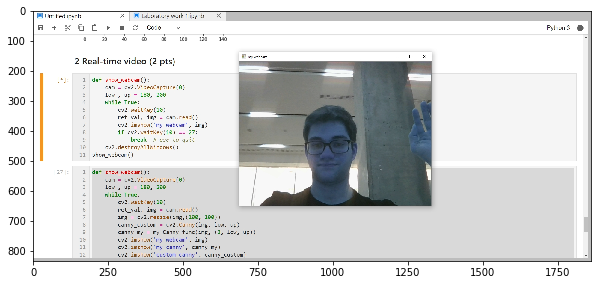

In [37]:
plt.figure(figsize=(10,7))
plt.imshow(cv2.imread(r"videocapture example.jpg"))

In [43]:
def show_webcam():
    cam = cv2.VideoCapture(0)
    low , up = 150, 200
    while True:
        cv2.waitKey(10)
        ret_val, img = cam.read()
        img = cv2.resize(img,(330, 330))
        canny_custom = cv2.Canny(img, low, up)
        canny_my = my_Canny_func(img, (3, low, up))
        cv2.imshow('my webcam', img)
        cv2.imshow('my canny', canny_my)
        cv2.imshow('custom canny', canny_custom)
        if cv2.waitKey(10) == 27: 
            break  # esc to quit
        if cv2.waitKey(10) == 105: # i - button. Increase value
            up += 5
            low += 5
            
            print ("setted up = ", up)
        if cv2.waitKey(10) == 111: # o - button. Decrease value
            up -= 5
            low -= 5
            print ("setted low = ", low)

    cv2.destroyAllWindows()
show_webcam()

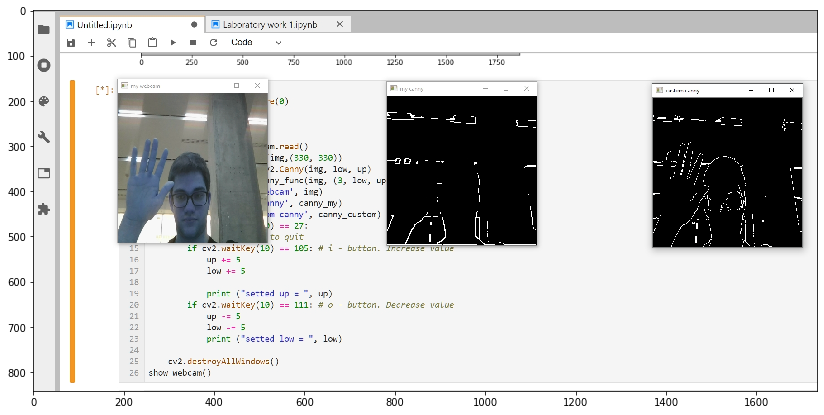

In [46]:
plt.figure(figsize=(15,7))
plt.imshow(cv2.imread(r"cunny vs cunny result.jpg"))

So, canny filter which was implemented by me, works withoy noise in compare with openCV.